In [ ]:
#shape = (10, 10)을 입력받아 랜덤한 RGBA 값을 가진 이미지를 생성해주는 함수
def random_image(shape = (10, 10)):
    img = np.random.randint(0, 256, shape + (4,), dtype=np.uint8)
    return img

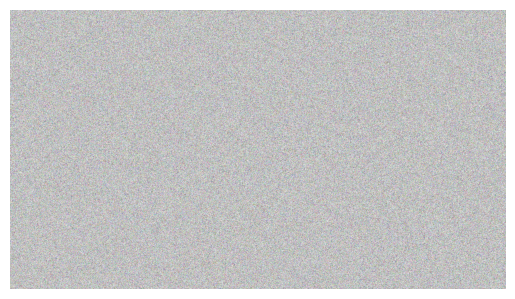

In [ ]:
# 100,100,4 (RGBA) 이미지를 plt로 출력해보자
img = random_image((1080,1920))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# ./data/origin.png 이미지를 불러와서 np.array로 변환해보자
from matplotlib import pyplot as plt
import numpy as np
origin_img = plt.imread('./data/origin.png')
# np.array의 0~1.0 값을 0~255 사이의 값으로 변환해보자
origin_img = origin_img * 255
origin_img = origin_img.astype(np.uint8)
origin_img.shape

(2168, 1931, 4)

In [ ]:
# (x,y,4) 이미지를 x,y 해상도로 ./data/1.png로 저장하기(plt 사용 금지)
from PIL import Image
from scipy import fftpack

# 1 원본
img = origin_img.copy()
img = Image.fromarray(img)
img.save('./data/1.png')

In [ ]:
# img를 해상도는 그대로 fft를 적용하여
# 손실압축한뒤 다시 원본 해상도로 복원하여 ./data/2.png로 저장하기
# x,y 해상도를 확인하고 각 해상도에 맞게 손실압축을 해야한다.
img = origin_img.copy()
img = fftpack.fft2(img)
img = fftpack.fftshift(img)

x, y = img.shape[0], img.shape[1]
# 손실압축
img[int(x*0.1):int(x*0.9), int(y*0.1):int(y*0.9)] = 0

img = fftpack.ifftshift(img)
img = fftpack.ifft2(img)
img = np.abs(img)
img = img.astype(np.uint8)
img = Image.fromarray(img)
img.save('./data/2.png')

In [ ]:
# (x,y,4) 이미지를 fft(빠른 푸리에 변환) 하여 (x,y,4) 이미지로 만들고
# 손실압축한뒤 다시 복원하여 (x,y,4) 이미지로 만들어보자
from scipy import fftpack
img = random_image((1080,1920))
img = fftpack.fft2(img)     # fft  : 빠른 푸리에 변환
# 손실압축
img[img < 100] = 0
img = fftpack.ifft2(img)    # ifft : 역 빠른 푸리에 변환
img = np.abs(img)           # abs  : 절대값
# 정수로 변환
img = img.astype(np.uint8)
img = Image.fromarray(img)
img.save('./data/2.png')


In [ ]:
# (x,y,4) 이미지를 fft(빠른 푸리에 변환) 하여 (x,y,4) 이미지로 만들고
# 손실압축한뒤 다시 복원하여 (x,y,4) 이미지로 만들어보자
from scipy import fftpack
img = random_image((1080,1920))
img = fftpack.fft2(img)     # fft  : 빠른 푸리에 변환
# 손실압축
img[img < 90] = 0
img = fftpack.ifft2(img)    # ifft : 역 빠른 푸리에 변환
img = np.abs(img)           # abs  : 절대값
# 정수로 변환
img = img.astype(np.uint8)
img = Image.fromarray(img)
img.save('./data/3.png')


In [ ]:
import cv2
import numpy as np

def compress_image_with_fft(image_path):
    # 이미지를 RGBA로 읽어오기
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error: Failed to read image file '{image_path}'")
        return
    
    # FFT 수행
    fft = np.fft.fft2(img[:, :, :3])
    fft_shift = np.fft.fftshift(fft)

    # 중심 범위 이외는 0으로 만듦(해상도 감소)    
    rows, cols, channels = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-16:crow+16, ccol-16:ccol+16] = 1
    fft_shift_masked = fft_shift * mask[:, :, np.newaxis]

    # Inverse FFT 수행
    fft_unshift = np.fft.ifftshift(fft_shift_masked)
    img_compressed_complex = np.fft.ifft2(fft_unshift)
    img_compressed = cv2.normalize(np.abs(img_compressed_complex[:, :, :3]), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # _fft 를 이미지 파일 이름 끝에 붙인 새로운 파일로 저장
    new_image_path = image_path.rsplit(".", 1)[0] + "_fft.png"
    cv2.imwrite(new_image_path, np.concatenate([img_compressed, img[:, :, 3:]], axis=2))
    
    return new_image_path


In [4]:
import cv2
import numpy as np

def compress_and_save(input_path, output_path = None):
    if output_path is None:
        output_path = input_path
    img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return False
    compressed_img = cv2.imencode('.png', img, [cv2.IMWRITE_PNG_COMPRESSION, 9])[1]
    nparr = np.frombuffer(compressed_img, np.uint8)
    img_encoded = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)
    output = output_path + '_fft.png'
    cv2.imwrite(output, img_encoded)
    return True


In [6]:
compress_and_save('./data/dot_dark.png')

True

In [8]:
import cv2
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift

def compress_and_save(input_path, output_path = None):
    if output_path is None:
        output_path = input_path
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False

    ## 2D FFT
    fft = fft2(img)

    ## High Frequency Elimination
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    fft_cut = fftshift(fft)
    fft_cut[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0
    fft_cut = fftshift(fft_cut)

    ## Inverse FFT
    ifft = ifft2(fft_cut)

    ## Normalization
    ifft = np.abs(ifft)
    min_val, max_val = np.min(ifft), np.max(ifft)
    ifft_normalized = ((ifft - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    ## 이미지 저장
    output_path += '_fft.png'
    cv2.imwrite(output_path, ifft_normalized)
    return True


In [11]:
compress_and_save('./data/origin.png')

True

In [24]:
import cv2
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift

def compress_and_save(input_path, output_path = None):
    if output_path is None:
        output_path = input_path
    # img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if img is None:
        return False
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    yuv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)

    ## U, V 채널 데이터 타입 astype(np.float32)로 변환
    u, v = yuv[:, :, 1].astype(np.float32), yuv[:, :, 2].astype(np.float32)

    ## 2D FFT
    u_fft = fft2(u)
    v_fft = fft2(v)

    ## High Frequency Elimination - U
    rows, cols = u.shape
    crow, ccol = rows // 2, cols // 2
    u_fft_cut = fftshift(u_fft)
    u_fft_cut[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0
    u_fft_cut = fftshift(u_fft_cut)

    ## High Frequency Elimination - V
    v_fft_cut = fftshift(v_fft)
    v_fft_cut[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0
    v_fft_cut = fftshift(v_fft_cut)

    ## Inverse FFT
    u_ifft = ifft2(u_fft_cut).real
    v_ifft = ifft2(v_fft_cut).real

    ## Normalization
    u_ifft = np.abs(u_ifft)
    v_ifft = np.abs(v_ifft)
    u_min_val, u_max_val = np.min(u_ifft), np.max(u_ifft)
    v_min_val, v_max_val = np.min(v_ifft), np.max(v_ifft)
    u_ifft_normalized = ((u_ifft - u_min_val) / (u_max_val - u_min_val) * 255).astype(np.uint8)
    v_ifft_normalized = ((v_ifft - v_min_val) / (v_max_val - v_min_val) * 255).astype(np.uint8)

    ## U, V 채널 손실압축된 이미지 생성
    yuv[:, :, 1] = u_ifft_normalized
    yuv[:, :, 2] = v_ifft_normalized

    ## YUV -> RGB 변환
    result = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

    ## 이미지 저장
    output_path += '_fft.png'
    cv2.imwrite(output_path, result)
    return True


In [25]:
compress_and_save('./data/origin.png')

True

In [2]:
import cv2
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift

def compress_and_save(input_path, output_path = None):
    if output_path is None:
        output_path = input_path
    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    yuv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)

    u, v = yuv_img[:, :, 1].astype(np.float32), yuv_img[:, :, 2].astype(np.float32)
    
    ## Check U, V channels
    cv2.imshow('u', u.astype(np.uint8))
    cv2.imshow('v', v.astype(np.uint8))

    ## 2D FFT
    u_fft = fft2(u)
    v_fft = fft2(v)

    ## High Frequency Elimination - U
    rows, cols = u.shape
    crow, ccol = rows // 2, cols // 2
    u_fft_cut = fftshift(u_fft)
    u_fft_cut[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0
    u_fft_cut = fftshift(u_fft_cut)

    ## High Frequency Elimination - V
    v_fft_cut = fftshift(v_fft)
    v_fft_cut[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0
    v_fft_cut = fftshift(v_fft_cut)

    ## Inverse FFT
    u_ifft = ifft2(u_fft_cut).real
    v_ifft = ifft2(v_fft_cut).real

    ## Normalization
    u_ifft = np.abs(u_ifft)
    v_ifft = np.abs(v_ifft)
    u_min_val, u_max_val = np.min(u_ifft), np.max(u_ifft)
    v_min_val, v_max_val = np.min(v_ifft), np.max(v_ifft)
    u_ifft_normalized = ((u_ifft - u_min_val) / (u_max_val - u_min_val) * 255).astype(np.uint8)
    v_ifft_normalized = ((v_ifft - v_min_val) / (v_max_val - v_min_val) * 255).astype(np.uint8)
    
    ## Check U, V channels
    cv2.imshow('U-channel', u_ifft_normalized)
    cv2.imshow('V-channel', v_ifft_normalized)
    cv2.waitKey(0)

    ## U, V 채널 손실압축된 이미지 생성
    yuv_img[:, :, 1] = u_ifft_normalized
    yuv_img[:, :, 2] = v_ifft_normalized

    ## YUV -> RGB 변환
    result = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

    ## 이미지 저장
    output_path += '_fft.png'
    cv2.imwrite(output_path, result)
    return True


In [3]:
compress_and_save('./data/dot_dark.png')

True

In [4]:
import cv2
import numpy as np
from scipy.fftpack import fft2, ifft2

def compress_and_save(input_path, output_path = None):
    if output_path is None:
        output_path = input_path
    # Read the input image
    img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    
    # Remove transparency by converting RGBA to RGB
    if img.shape[2] >= 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    
    # Convert to YUV color space
    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    # 4:1:1 chroma subsampling
    y, u, v = cv2.split(yuv_img)
    u_subsampled = cv2.resize(u, (y.shape[1] // 2, y.shape[0] // 2))
    v_subsampled = cv2.resize(v, (y.shape[1] // 2, y.shape[0] // 2))

    # FFT, remove higher frequencies, and then IFFT
    u_fft = fft2(u_subsampled)
    v_fft = fft2(v_subsampled)
    
    u_fft[50:-50, 50:-50] = 0
    v_fft[50:-50, 50:-50] = 0
    
    u_ifft = np.abs(ifft2(u_fft)).astype(np.uint8)
    v_ifft = np.abs(ifft2(v_fft)).astype(np.uint8)

    # Upscale u and v channels
    u_upsampled = cv2.resize(u_ifft, (y.shape[1], y.shape[0]), interpolation=cv2.INTER_LINEAR)
    v_upsampled = cv2.resize(v_ifft, (y.shape[1], y.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Merge channels
    yuv_result = cv2.merge((y, u_upsampled, v_upsampled))

    # Convert back to RGB
    rgb_result = cv2.cvtColor(yuv_result, cv2.COLOR_YUV2RGB)

    # Save the output image
    output_filename = output_path + '_zip.png'
    cv2.imwrite(output_filename, rgb_result)


In [5]:
compress_and_save('./data/origin.png')

In [13]:
import cv2

def compress_and_save(input_path, output_path=None, subsampling='420'):
    if output_path is None:
        output_path = input_path

    # 이미지 불러오기 및 투명도 제거
    image = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    # YUV 형식으로 변환
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # UV 채널 손실 압축
    subsampling_methods = {
        '444': (1, 1),
        '422': (2, 1),
        '420': (2, 2),
        '411': (4, 1),
    }
    if subsampling in subsampling_methods:
        ratio = subsampling_methods[subsampling]
        yuv_image[:, :, 1:3] = cv2.resize(cv2.resize(yuv_image[:, :, 1:3], (0, 0), fx=1 / ratio[0], fy=1 / ratio[1]), (image.shape[1], image.shape[0]))

    # RGB 형식으로 변환
    result_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

    # 결과 이미지 저장
    output_filename = output_path + '_{}_zip.png'.format(subsampling)
    cv2.imwrite(output_filename, result_image)

    return output_filename


In [14]:
compress_and_save('./data/dot_light.png')
compress_and_save('./data/dot_light.png', subsampling='422')
compress_and_save('./data/dot_light.png', subsampling='411')

'./data/dot_light.png_411_zip.png'

In [23]:
subsmpl = ['444', '422', '420', '411']
for sub in subsmpl:
    compress_and_save('./data/origin.png', subsampling=sub)

In [15]:
# 100x100 랜덤 RGB 이미지를 n개 만들고, ./data/random_image{i:02d}.png로 저장한다.
def make_rand_img(n):
    for i in range(n):
        img = np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8)
        cv2.imwrite('./data/random_image{:02d}.png'.format(i), img)

In [16]:
make_rand_img(2)

In [18]:
# The following code compresses a random image and saves it to a file.
# It does this three times, each with a different subsampling mode.
# The code is split into two parts: the first part sets up the parameters
# and the second part does the actual compression.
file_name = './data/random_image{:02d}.png'
subsmpl = ['422', '420', '411']
for i in range(2):
    for sub in subsmpl:
        compress_and_save(file_name.format(i), subsampling=sub)

In [ ]:
# rgv_to_yuv 함수를 python으로 구현해줘.